In [1]:
from google.colab import drive
import os

drive.mount('/content/gdrive')
path = "/content/gdrive/My Drive/My Projects/NLP_Master/hw1"
os.chdir(path)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip install Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Cosine Similarity



In [3]:
import numpy as np 
from numpy.linalg import norm
import pandas as pd
from scipy import spatial
import math
from Levenshtein import ratio as lev_ratio
import Levenshtein as lev

def squared_sum(x):
  """ return 3 rounded square rooted value """
 
  return round(math.sqrt(sum([a*a for a in x])),3)

def cosine_similarity_(x, y):
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)

  return round(numerator/float(denominator),3)
  
def cosine_similarity(a, b):
  cos_sim = np.dot(a, b)/(norm(a)*norm(b))
  return cos_sim

def pearson_correlation(x, y):
    ''' Return correlation coeficient of x and y.
    x, y: are two numpy arrays. Both x and y should have the same size
    '''
    assert len(x)==len(y)
    cov = 0
    for i in range(len(x)):
        if x[i] is np.nan or y[i] is np.nan:
            continue
        try:
            a = float(x[i])
            b = float(y[i])
            cov += ((a-np.mean(x))*(b-np.mean(y)))
        except:
            return None
    cov = cov / len(x)
    corr = cov / (np.std(x) * np.std(y))
                
    return corr

In [4]:
# from scipy import spatial
# spatial.distance.cosine(list1, list2)

### Solving the out-of-vocab problem with Levenshtein althogithm

In [5]:
def load_word2vec_txt(path="W2V_150.txt"):
  with open(path, "r") as file:
    words = file.readlines()[2:]

  word2vec = {}
  for word in words:
    split_raw_str = word.split()
    key = split_raw_str[0]
    value = [float(i) for i in split_raw_str[1:]]
    word2vec[key] = value
    
  return word2vec

def get_oov_from_Lev_ratio(input, word2vec):
  vocab = word2vec.keys()
  best_score = 0
  best_word = ""

  lev_score_dic = {}
  for word in vocab:
    lev_score = lev_ratio(input, word)
    lev_score_dic[word] = lev_score

  sorted_lev_score_dic = sorted(lev_score_dic.items(), key=lambda x:x[1], reverse=True)
  
  lev_vec = []
  for priotity_words in sorted_lev_score_dic[:3]:
    lev_vec.append(word2vec[priotity_words[0]])

  return np.mean(lev_vec, axis=0)
  

def get_vector(word, word2vec):
  if word in word2vec.keys():
    vec = word2vec[word]
  else: 
    # if word not in vocab then get vector equal average 3 best lev vectors
    vec = get_oov_from_Lev_ratio(word, word2vec)

  return vec

In [6]:
word2vec = load_word2vec_txt()

### Testing

In [7]:
Visim_df = pd.read_csv("Visim-400.txt", sep="\t", header=0)

In [8]:
cosine_arr = []
# cosine_arr_ = []
for i in range(len(Visim_df)):
  word1 = Visim_df['Word1'].iloc[i]
  word2 = Visim_df['Word2'].iloc[i]

  # if True:
  # try:
  cosine_score = cosine_similarity(get_vector(word1, word2vec), get_vector(word2, word2vec))
    # cosine_score_ = cosine_similarity_(word2vec[word1], word2vec[word2])
  # except:
    # cosine_score = None
    # cosine_score_ = None

  cosine_arr.append(cosine_score)
  # cosine_arr_.append(cosine_score_)

Visim_df['cosine_similarity'] = cosine_arr 
# Visim_df['cosine_similarity_'] = cosine_arr_ 

In [9]:
Visim_df.sort_values(by=['cosine_similarity'])

,Word1,Word2,POS,Sim1,Sim2,STD,cosine_similarity
110,chỉnh_hình,luồng,N,0.53,0.88,1.02,-0.173409
19,đổ_bê_tông,biếu_xén,V,0.33,0.55,0.60,-0.172840
101,phôi_bào,tế_bào,N,4.13,6.88,1.15,-0.136567
192,bạc_đãi,trọng_đãi,V,0.67,1.12,0.79,-0.119938
336,nền,cận_cảnh,N,1.80,3.00,0.75,-0.117092
...,...,...,...,...,...,...,...
48,vẹo,vẹo_vọ,A,4.93,8.22,0.93,0.779414
341,nguyên_nhân,nguyên_do,N,5.93,9.88,0.25,0.817989
229,thìa,muỗng,N,4.67,7.78,0.87,0.842298
179,thuở,thủa,N,5.87,9.78,0.34,0.861469


# K-nearest words

In [10]:
def get_k_nearest(input, word2vec, k=5):
  # is input word in vocab?
  if input not in word2vec.keys():
    return None

  word2simscore = {}
  for key, value in word2vec.items():
    word2simscore[key] = cosine_similarity(get_vector(input, word2vec), value)
  sorted_word2simscore = sorted(word2simscore.items(), key=lambda x:x[1], reverse=True)
  # print(sorted_word2simscore)

  return sorted_word2simscore[1:k+1]

get_k_nearest(input="mong_chờ", word2vec=word2vec, k=10)

[('mong_ngóng', 0.7656145425035378),
 ('trông_đợi', 0.7635851646547285),
 ('chờ_đợi', 0.7577841776545142),
 ('chờ_mong', 0.7129734989880835),
 ('ngóng_chờ', 0.6768337272969206),
 ('mong_đợi', 0.6670756782928458),
 ('ngóng_đợi', 0.6464718558082261),
 ('mong_mỏi', 0.6256198478006758),
 ('trông_ngóng', 0.6159889189980208),
 ('kỳ_vọng', 0.5938236123090951)]

# Synonym-antonym classification

In [11]:
def load_cls_txt(path, define_label=1):
  with open(path) as file:
    word_pairs = file.readlines()
  
  word_pairs_arr, labels = [], []
  for pair in word_pairs:
    splited_pair = pair.split()
    if len(splited_pair)!=2:
      continue
    word_pairs_arr.append(pair.split())
    labels.append(define_label)


  return word_pairs_arr, labels

In [12]:
antonym_word_pairs, antonym_labels = load_cls_txt("Antonym_vietnamese.txt", 0)
synonym_word_pairs, synonym_labels = load_cls_txt("Synonym_vietnamese.txt", 1)

total_words = antonym_word_pairs + synonym_word_pairs
total_labels = antonym_labels + synonym_labels

In [22]:
len(total_words)

13558

In [13]:
for word in total_words:
  if len(word) < 2:
    print(word)

### Training

In [14]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8, 8), dpi=80)

def plot_losses(losses):
  plt.plot(losses, '-b', label='std=0.2')
  plt.xlabel("Epochs")
  plt.ylabel("losses")
  plt.legend(loc='upper left')
  plt.show()

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(300, 512),
      nn.ReLU(),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, 1),
      nn.Sigmoid()
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

class Logistic(nn.Module):
  '''
     Logistic Regression  .
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(300, 100),
      nn.Linear(100,1),
      nn.Sigmoid(),
      # nn.Linear(2, 1),
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

class SynonymAntonymDatset(Dataset):
  def __init__(self, word_pairs, labels, word2vec) -> None:
      self.word_pairs = word_pairs
      self.labels = labels
      self.word2vec = word2vec

  def __len__(self):
    return len(self.word_pairs)

  def __getitem__(self, idx):
    word1, word2 = self.word_pairs[idx]
    label = self.labels[idx]

    word1_vec = get_vector(word1, self.word2vec)
    word2_vec = get_vector(word2, self.word2vec)

    word_emb = np.concatenate((word1_vec, word2_vec), axis=0)

    input = torch.Tensor(word_emb)
    target = torch.tensor(float(label))

    return input, target

def training_fn(mlp, X, y, X_test, y_test, optimizer, epochs=10, device="cuda"):
  dataset = SynonymAntonymDatset(X, y, word2vec)
  test_dataset = SynonymAntonymDatset(X_test, y_test, word2vec)

  trainloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)
  testloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)
  
  # Initialize the MLP
  
  # Define the loss function and optimizer
  # loss_function = nn.BCEWithLogitsLoss()
  loss_function = nn.BCELoss()
  # loss_function = nn.MSELoss()
  
  # Run the training loop
  total_losses = []
  test_loss = []
  best_score = 0
  re = []
  for epoch in range(0, epochs): # 5 epochs at maximum
    current_loss = 0
    mlp.train()
    train_total_correct = 0

    # Iterate over the DataLoader for training data
    for data in tqdm(trainloader, 0):      
      # Get inputs
      inputs, targets = data[0].to(device), data[1].to(device)
      
      # Zero the gradients
      optimizer.zero_grad()
      
      # Perform forward pass
      outputs = mlp(inputs)
      
      # Compute loss
      loss = loss_function(outputs, targets.unsqueeze(1))
      
      
      # Perform backward pass
      loss.backward()
      
      # Perform optimization
      optimizer.step()
      
      # Print statistics
      current_loss += loss.item()

      outputs = outputs.squeeze() > 0.5
      corrects = ((outputs) == targets).sum()
      train_total_correct += corrects

      del outputs, targets, corrects
    
    mlp.eval()
    total_correct = 0 
    test_loss = 9
    for data in testloader:
      with torch.no_grad():
        inputs, targets = data[0].to(device), data[1].to(device)
        outputs = mlp(inputs)
        loss = loss_function(outputs, targets.unsqueeze(1))
        # outputs = torch.sigmoid(outputs.squeeze()) > 0.5 
        outputs = outputs.squeeze() > 0.5
        targets = targets > 0.5
        corrects = ((outputs) == targets).sum()
        total_correct += corrects
    if best_score < total_correct:
      best_score = total_correct
    print("Epoch: {}, Training loss: {}, Training accuracy: {}, Validation accuracy: {}".format(epoch+1, current_loss/i, train_total_correct/len(y), total_correct/len(y_test)))
    total_losses.append(current_loss/i)
    re.append(train_total_correct/len(y))

    current_loss = 0.0
  return total_losses, best_score/len(y_test), re

<Figure size 640x640 with 0 Axes>

In [15]:
X_train, X_test, y_train, y_test = train_test_split(total_words, total_labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
device = torch.device("cuda")

  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 1, Training loss: 0.4235777052243084, Training accuracy: 0.9002151489257812, Validation accuracy: 0.9225806593894958


  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 2, Training loss: 0.19609471187077201, Training accuracy: 0.9557422399520874, Validation accuracy: 0.94654381275177


  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 3, Training loss: 0.08626855390528883, Training accuracy: 0.9802274107933044, Validation accuracy: 0.9539170861244202


  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 4, Training loss: 0.05719918580470128, Training accuracy: 0.9872963428497314, Validation accuracy: 0.9603686928749084


  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 5, Training loss: 0.032086746135025705, Training accuracy: 0.9935457110404968, Validation accuracy: 0.9658986330032349


  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 6, Training loss: 0.027656480652537032, Training accuracy: 0.9978485703468323, Validation accuracy: 0.9658986330032349


  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 7, Training loss: 0.06517725616721325, Training accuracy: 0.9897551536560059, Validation accuracy: 0.9576036930084229


  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 8, Training loss: 0.03647992027184554, Training accuracy: 0.9917016625404358, Validation accuracy: 0.9677419662475586


  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 9, Training loss: 0.01770893606930897, Training accuracy: 0.9965167045593262, Validation accuracy: 0.9631336331367493


  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 10, Training loss: 0.04108108528006031, Training accuracy: 0.9944677352905273, Validation accuracy: 0.9668202996253967


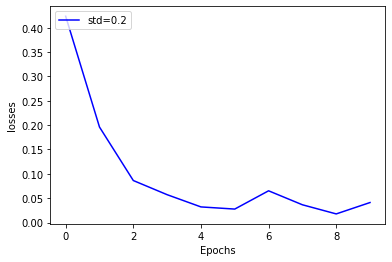

In [16]:
model_mlp = MLP()
model_mlp = model_mlp.to(device)

# optimizer = torch.optim.SGD(model_mlp.parameters(), lr=0.01)
optimizer_mlp = torch.optim.Adam(model_mlp.parameters(), lr=1e-3)

mlp_train_loss, _, _ = training_fn(model_mlp, X_train, y_train, X_val, y_val, optimizer_mlp)
plot_losses(mlp_train_loss)

In [17]:
model_logistic = Logistic()
model_logistic = model_logistic.to(device)

# optimizer = torch.optim.SGD(model_logistic.parameters(), lr=0.01)
optimizer_logistic = torch.optim.Adam(model_logistic.parameters(), lr=1e-3)

logis_train_loss, _, _ = training_fn(model_logistic, X_train, y_train, X_val, y_val, optimizer_logistic)

  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 1, Training loss: 0.5247468799352646, Training accuracy: 0.8654850721359253, Validation accuracy: 0.8571428656578064


  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 2, Training loss: 0.4677400415702571, Training accuracy: 0.8791107535362244, Validation accuracy: 0.8580645322799683


  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 3, Training loss: 0.45691575574919696, Training accuracy: 0.8812621235847473, Validation accuracy: 0.8635944724082947


  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 4, Training loss: 0.45217508394364503, Training accuracy: 0.8796229958534241, Validation accuracy: 0.8672811388969421


  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 5, Training loss: 0.44786179381280317, Training accuracy: 0.8833110928535461, Validation accuracy: 0.8608295321464539


  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 6, Training loss: 0.4451928165248761, Training accuracy: 0.8811597228050232, Validation accuracy: 0.8663594722747803


  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 7, Training loss: 0.44419261915866, Training accuracy: 0.8820817470550537, Validation accuracy: 0.8626728057861328


  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 8, Training loss: 0.43913510738682926, Training accuracy: 0.8850527405738831, Validation accuracy: 0.861751139163971


  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 9, Training loss: 0.44135323315298647, Training accuracy: 0.8845404982566833, Validation accuracy: 0.8635944724082947


  0%|          | 0/611 [00:00<?, ?it/s]

Epoch: 10, Training loss: 0.44004797100796733, Training accuracy: 0.8857699036598206, Validation accuracy: 0.8645161390304565


### Evaluation

In [45]:
from sklearn.metrics import classification_report
def evaluation_fn(model, X_test, y_test):
  test_dataset = SynonymAntonymDatset(X_test, y_test, word2vec)
  testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

  predicts_list = []
  targets_list = []
  for idx, data in enumerate(testloader):
        with torch.no_grad():
          inputs, targets = data[0].to(device), data[1].to(device)
          outputs = model(inputs)
          # outputs = torch.sigmoid(outputs.squeeze()) > 0.5 
          outputs = outputs.squeeze() > 0.5
          targets = targets > 0.5

          if outputs!=targets:
            print(X_test[idx])
            print(outputs)
            print(targets)
            print("***************************")

          predicts_list.append(outputs.cpu().numpy())
          targets_list.append(targets.cpu().numpy())

  print(classification_report(targets_list, predicts_list))
  

In [46]:
evaluation_fn(model_mlp, X_test, y_test)

['quê_kệch', 'quê_mùa']
tensor(False, device='cuda:0')
tensor([True], device='cuda:0')
***************************
['rét', 'lạnh']
tensor(False, device='cuda:0')
tensor([True], device='cuda:0')
***************************
['đầy', 'vơi']
tensor(True, device='cuda:0')
tensor([False], device='cuda:0')
***************************
['bít', 'bịt']
tensor(False, device='cuda:0')
tensor([True], device='cuda:0')
***************************
['bằng_phẳng', 'nhấp_nhô']
tensor(True, device='cuda:0')
tensor([False], device='cuda:0')
***************************
['xắn', 'trải']
tensor(True, device='cuda:0')
tensor([False], device='cuda:0')
***************************
['chần_chờ', 'dứt_khoát']
tensor(True, device='cuda:0')
tensor([False], device='cuda:0')
***************************
['chín', 'xanh_lè']
tensor(True, device='cuda:0')
tensor([False], device='cuda:0')
***************************
['thiệt_thà', 'gian_giảo']
tensor(True, device='cuda:0')
tensor([False], device='cuda:0')
***********************

In [20]:
evaluation_fn(model_logistic, X_test, y_test)

              precision    recall  f1-score   support

       False       0.68      0.40      0.51       408
        True       0.90      0.97      0.93      2304

    accuracy                           0.88      2712
   macro avg       0.79      0.69      0.72      2712
weighted avg       0.87      0.88      0.87      2712

